<a href="https://colab.research.google.com/github/ARt2406/Crypto/blob/main/Crypto_withSMA_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

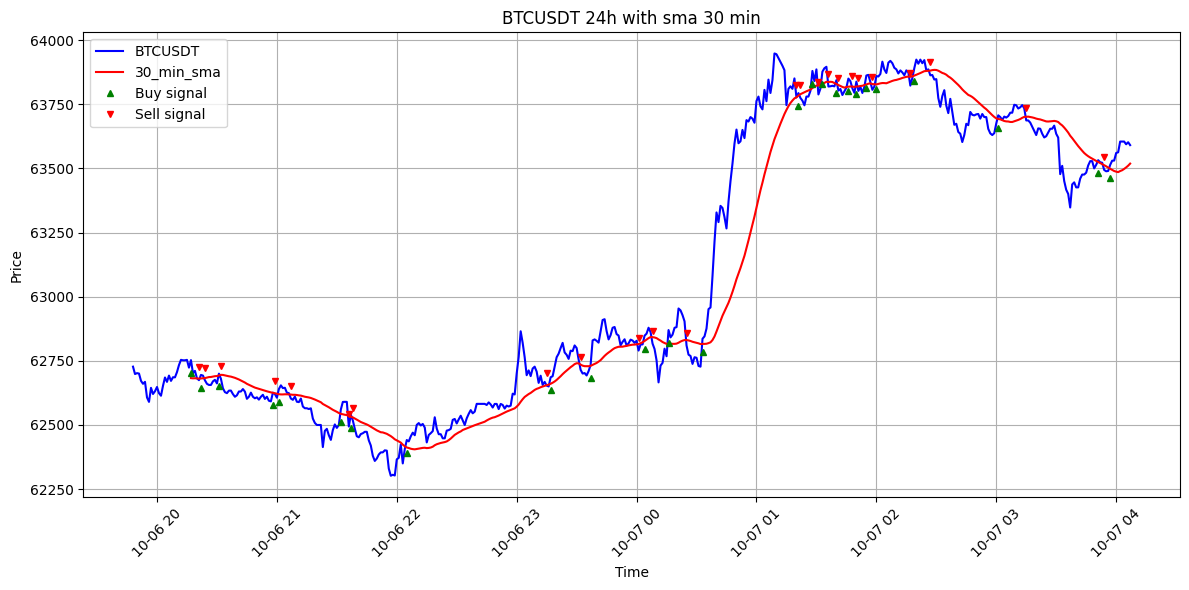

Buy signals: 25
Sell signals: 24


In [10]:

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_crypto_prices(symbol) -> pd.DataFrame:
    end_time = int(datetime.now().timestamp() * 1000)
    start_time = int((datetime.now() - timedelta(days=1)).timestamp() * 1000)

    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1m&startTime={start_time}&endTime={end_time}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['price'] = df['close'].astype(float)

        return df[['time', 'price']]
    else:
        print(f'Error: {response.status_code}')
        return pd.DataFrame()

def get_chart_sma_signal(symbol: str) -> pd.DataFrame:
    df = get_crypto_prices(symbol)

    if not df.empty:
        plt.figure(figsize=(12, 6))

        # плотим цену
        plt.plot(df['time'], df['price'], label=symbol, color='blue')


        # Добавляем скользящую среднюю за 30 минут
        df['sma_30'] = df['price'].rolling(window=30).mean()
        plt.plot(df['time'], df['sma_30'], label='30_min_sma', color='red')

        # Генерируем сигнал
        df['signal'] = np.where(df['price'] > df['sma_30'], 1, 0)
        df['position'] = df['signal'].diff()

        # Отмечаем сигналы на графике
        plt.plot(df[df['position'] == 1].time,
                 df[df['position'] == 1].price - 50,
                 '^', markersize=5, color='g', label='Buy signal')

        plt.plot(df[df['position'] == - 1].time,
                 df[df['position'] == - 1].price + 50,
                 'v', markersize=5, color='r', label='Sell signal')

        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title(f'{symbol} 24h with sma 30 min')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Выводим количество сигналов
        buy_signal = df[df['position'] == 1].shape[0]
        sell_signal = df[df['position'] == -1].shape[0]
        print(f'Buy signals: {buy_signal}')
        print(f'Sell signals: {sell_signal}')
    else:
        print('Error')

get_chart_sma_signal(symbol='BTCUSDT')

